In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader
import os
import sys
import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import accuracy_score

## Preprocess data

In [27]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

In [46]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

train_set.head()

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?


In [47]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [48]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [49]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [50]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [51]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)

  x = torch.tensor(np.array(padded_sentences))

  return x

In [52]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)
test_set = encode_y_label(test_set, 5)

In [53]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

X_test = preprocess_x(test_set)
y_test = test_set['encoded-coarse-label']

# mini-batch strategy
batch_size = 32

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)
test_data = CustomDataset(X_test, y_test)

/var/folders/s6/9xhy3ssd0snfcfh5ys7848y40000gn/T/ipykernel_2400/1626110238.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


In [184]:
# model

class WordRNNGRU(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WordRNNGRU, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.dense = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        # byte_vectors = nn.functional.one_hot(x, num_classes=input_dim).float()

        # encoding, _ = self.rnn(byte_vectors)

        # pooled_output = nn.functional.max_pool1d(encoding, kernel_size=encoding.size(2))
        # pooled_output = pooled_output.permute(0, 2, 1)  # Restore original dimensions

        # encoding = encoding[:, -1, :]
        # encoding = nn.functional.dropout(encoding, drop_rate)
        # logits = self.dense(encoding)
        # return logits

        encoding, _ = self.rnn(x)

        pooled_output = F.max_pool2d(encoding, kernel_size=(encoding.size(1), 1), stride=(encoding.size(1), 1))

        output = self.dense(pooled_output)
        
        logits = self.softmax(output)
        return logits
    

seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

In [185]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    

def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [192]:
input_dim = 300
hidden_dim = 128
output_dim = 5
model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [195]:
num_epochs = 100
best_accuracy = 0.0
max_patience = 5
current_patience = 0
dev_accuracy_list = []
run_time = []

train_loader = DataLoader(train_data, batch_size=24, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=24, shuffle=True)

for epoch in range(num_epochs):
  model.train()
  total_training_loss = 0.0
  total_dev_loss = 0.0
  start_time_epoch = time.time()

  for x_batch, y_batch in train_loader:
    outputs = model(x_batch.float()) # forward pass
    optimizer.zero_grad() # calculate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs.squeeze(1), y_batch)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop

    total_training_loss += loss.item()

  average_loss = total_training_loss / len(train_loader)
  print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

  # evaluate on dev set
  model.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []
    for inputs in dev_loader:
      x_batch, y_batch = inputs

      # forward pass
      y_pred = model(x_batch.float())
      loss = criterion(y_pred.squeeze(1), y_batch)

      total_dev_loss += loss.item()

      predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

      y_batch = torch.argmax(y_batch, dim=1)

      all_true_labels.extend(y_batch.tolist())
      all_predicted_labels.extend(predicted_labels.tolist())

    average_dev_loss = total_dev_loss / len(dev_loader)
    print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))

  accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
  dev_accuracy_list.append(accuracy)
  print(f"Accuracy: {accuracy * 100:.2f}%")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = model.state_dict()
  else:
    current_patience += 1
    if current_patience >= max_patience:
        print(f"Early stopping after {epoch} epochs.")
        end_time_epoch = time.time()
        time_taken = end_time_epoch - start_time_epoch
        run_time.append(time_taken)
        total_time_taken = sum(run_time)
        print(f"Time taken to run the model with optimal parameters: {total_time_taken} seconds ")
        break
    
  end_time_epoch = time.time()
  time_taken = end_time_epoch - start_time_epoch
  run_time.append(time_taken)


Epoch: 0, training set loss: 1.43140
Epoch: 0, dev set loss: 1.26341
Accuracy: 69.80%
Epoch: 1, training set loss: 1.23007
Epoch: 1, dev set loss: 1.19995
Accuracy: 70.20%
Epoch: 2, training set loss: 1.18045
Epoch: 2, dev set loss: 1.16202
Accuracy: 74.80%
Epoch: 3, training set loss: 1.14403
Epoch: 3, dev set loss: 1.14625
Accuracy: 76.00%
Epoch: 4, training set loss: 1.12713
Epoch: 4, dev set loss: 1.14638
Accuracy: 74.80%
Epoch: 5, training set loss: 1.10479
Epoch: 5, dev set loss: 1.13501
Accuracy: 76.00%
Epoch: 6, training set loss: 1.08814
Epoch: 6, dev set loss: 1.14019
Accuracy: 76.40%
Epoch: 7, training set loss: 1.07983
Epoch: 7, dev set loss: 1.12489
Accuracy: 77.80%
Epoch: 8, training set loss: 1.07061
Epoch: 8, dev set loss: 1.11794
Accuracy: 78.60%
Epoch: 9, training set loss: 1.06134
Epoch: 9, dev set loss: 1.12220
Accuracy: 77.80%
Epoch: 10, training set loss: 1.05102
Epoch: 10, dev set loss: 1.12472
Accuracy: 78.20%
Epoch: 11, training set loss: 1.04335
Epoch: 11, dev

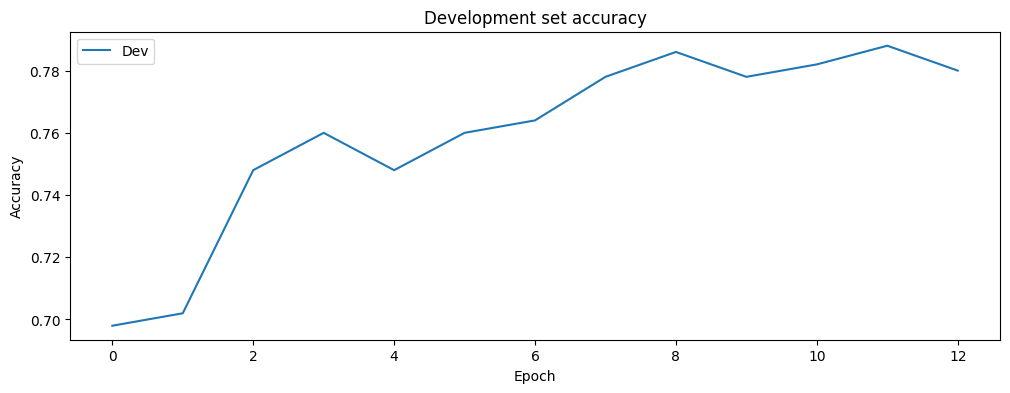

In [198]:
# Plot train and dev accurancies and losses on training and dev data against training epochs
plt.figure(figsize=(12, 4))
plt.title('Development set accuracy')
plt.plot(range(len(dev_accuracy_list)), dev_accuracy_list, label='Dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Find optimal batch size

In [ ]:
input_dim = 300
hidden_dim = 128
output_dim = 5
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
model = WordRNNGRU(input_dim, hidden_dim = hidden_dim, output_dim = output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper()

In [ ]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [ ]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  model = simple_lstm(input_dim, 128, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break 
      
  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time 
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.31112
Epoch: 0, dev set loss: 1.18629
Accuracy: 72.60%
Epoch: 1, training set loss: 1.20371
Epoch: 1, dev set loss: 1.16453
Accuracy: 73.40%
Epoch: 2, training set loss: 1.15417
Epoch: 2, dev set loss: 1.12816
Accuracy: 77.20%
Epoch: 3, training set loss: 1.12428
Epoch: 3, dev set loss: 1.14349
Accuracy: 75.60%
Epoch: 4, training set loss: 1.10002
Epoch: 4, dev set loss: 1.15411
Accuracy: 75.40%
Epoch: 5, training set loss: 1.08448
Epoch: 5, dev set loss: 1.10939
Accuracy: 79.00%
Epoch: 6, training set loss: 1.06187
Epoch: 6, dev set loss: 1.11493
Accuracy: 78.40%
Epoch: 7, training set loss: 1.05146
Epoch: 7, dev set loss: 1.11090
Accuracy: 79.20%
Epoch: 8, training set loss: 1.03764
Epoch: 8, dev set loss: 1.11963
Accuracy: 78.00%
Epoch: 9, training set loss: 1.02857
Epoch: 9, dev set loss: 1.13369
Accuracy: 76.20%
Epoch: 10, training set loss: 1.01850
Epoch: 10, dev set loss: 1.10940
Accuracy: 78.60%
Epoch: 11, training set loss: 1.00446
Epoch: 11, dev

In [ ]:
accuracy_list_batch_size

{2: 0.7827,
 4: 0.7918999999999999,
 8: 0.767,
 16: 0.7753,
 24: 0.7705000000000002,
 32: 0.7537,
 64: 0.7414,
 128: 0.7215,
 256: 0.6832,
 512: 0.626}

Text(0.5, 1.0, 'Accuracy against Batch size')

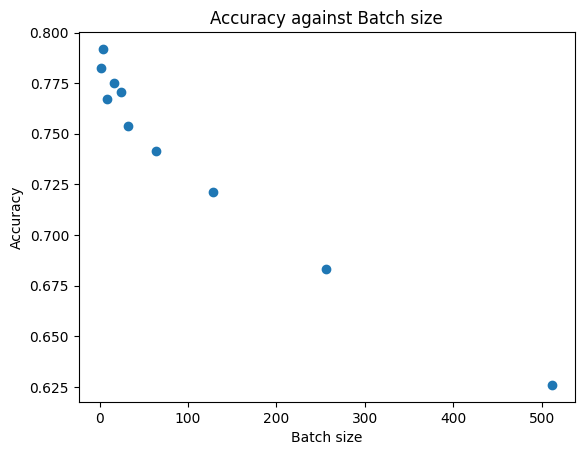

In [ ]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

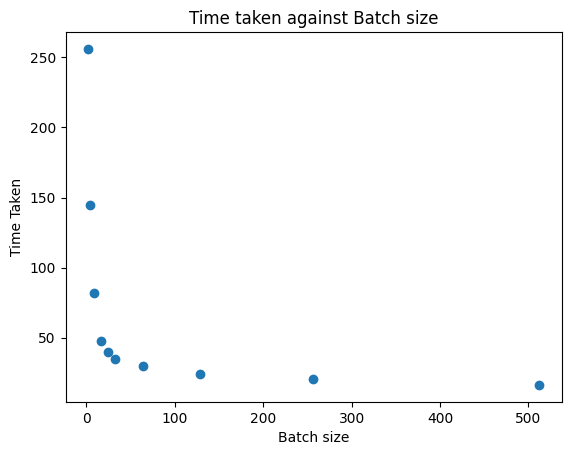

In [ ]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")